# Convolutional Networks

So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [1]:
# As usual, a bit of setup
import numpy as np
import matplotlib.pyplot as plt
from annp.classifiers.cnn import *
from annp.data_utils import get_CIFAR10_data
from annp.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from annp.layers import *
from annp.fast_layers import *
from annp.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Convolution: Naive forward pass
The core of a convolutional network is the convolution operation. In the file `annp/layers.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [3]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be between 1e-9 and 1e-7
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


# Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

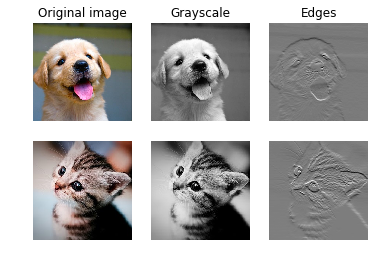

In [4]:
from imageio import imread
from PIL import Image

kitten = imread('annp/notebook_images/kitten.jpg')
puppy = imread('annp/notebook_images/puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = np.array(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = np.array(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = resized_puppy.transpose((2, 0, 1))
x[1, :, :, :] = resized_kitten.transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

# Convolution: Naive backward pass
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `annp/layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [5]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be between 1e-7 and 1e-9 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.159803161159293e-08
dw error:  2.247109434939654e-10
db error:  3.37264006649648e-11


# Max-Pooling: Naive forward
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `annp/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [6]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


# Max-Pooling: Naive backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `annp/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [7]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


# Fast layers

Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `annp/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; before using it please execute the command in local development cell in your terminal. 

## Local Development

Go to the annp directory and execute the following in your terminal:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [8]:
# Rel errors should be around e-9 or less
from annp.fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 0.159572s
Fast: 0.011968s
Speedup: 13.332815x
Difference:  4.926407851494105e-11

Testing conv_backward_fast:
Naive: 0.371016s
Fast: 0.009989s
Speedup: 37.142325x
dx difference:  1.949764775345631e-11
dw difference:  8.92268342061343e-14
db difference:  0.0


In [9]:
# Relative errors should be close to 0.0
from annp.fast_layers import max_pool_forward_fast, max_pool_backward_fast
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.006948s
fast: 0.004022s
speedup: 1.727564x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.013964s
fast: 0.010986s
speedup: 1.271155x
dx difference:  0.0


# Convolutional "sandwich" layers
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `annp/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks. Run the cells below to sanity check they're working.

In [10]:
from annp.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

# Relative errors should be between 1e-7 and 1e-9 or less
print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  9.591132621921372e-09
dw error:  5.802401370096438e-09
db error:  1.0146343411762047e-09


In [11]:
from annp.layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

# Relative errors should be between 1e-7 and 1e-9 or less
print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  1.5218619980349303e-09
dw error:  2.702022646099404e-10
db error:  1.451272393591721e-10


# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `annp/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Remember you can use the fast/sandwich layers (already imported for you) in your implementation. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization the loss should go up slightly.

In [12]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.302586071243987
Initial loss (with regularization):  2.508255638232932


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to the order of e-2.

In [13]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [14]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 30) loss: 2.414060
(Epoch 0 / 15) train acc: 0.200000; val_acc: 0.137000
(Iteration 2 / 30) loss: 3.102925
(Epoch 1 / 15) train acc: 0.140000; val_acc: 0.087000
(Iteration 3 / 30) loss: 2.270330
(Iteration 4 / 30) loss: 2.096705
(Epoch 2 / 15) train acc: 0.240000; val_acc: 0.094000
(Iteration 5 / 30) loss: 1.838880
(Iteration 6 / 30) loss: 1.934188
(Epoch 3 / 15) train acc: 0.510000; val_acc: 0.173000
(Iteration 7 / 30) loss: 1.827912
(Iteration 8 / 30) loss: 1.639574
(Epoch 4 / 15) train acc: 0.520000; val_acc: 0.188000
(Iteration 9 / 30) loss: 1.330082
(Iteration 10 / 30) loss: 1.756115
(Epoch 5 / 15) train acc: 0.630000; val_acc: 0.167000
(Iteration 11 / 30) loss: 1.024162
(Iteration 12 / 30) loss: 1.041826
(Epoch 6 / 15) train acc: 0.750000; val_acc: 0.229000
(Iteration 13 / 30) loss: 1.142777
(Iteration 14 / 30) loss: 0.835706
(Epoch 7 / 15) train acc: 0.790000; val_acc: 0.247000
(Iteration 15 / 30) loss: 0.587786
(Iteration 16 / 30) loss: 0.645509
(Epoch 8 / 15) tr

In [15]:
# Print final training accuracy
print(
    "Small data training accuracy:",
    solver.check_accuracy(small_data['X_train'], small_data['y_train'])
)

Small data training accuracy: 0.82


In [16]:
# Print final validation accuracy
print(
    "Small data validation accuracy:",
    solver.check_accuracy(small_data['X_val'], small_data['y_val'])
)

Small data validation accuracy: 0.252


Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

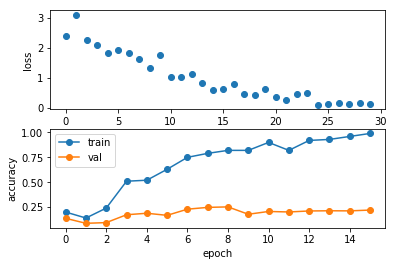

In [17]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [18]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.304740
(Epoch 0 / 1) train acc: 0.103000; val_acc: 0.107000
(Iteration 21 / 980) loss: 2.097586
(Iteration 41 / 980) loss: 1.943520
(Iteration 61 / 980) loss: 1.846140
(Iteration 81 / 980) loss: 1.764751
(Iteration 101 / 980) loss: 1.719218
(Iteration 121 / 980) loss: 1.589498
(Iteration 141 / 980) loss: 1.858977
(Iteration 161 / 980) loss: 2.027012
(Iteration 181 / 980) loss: 1.793077
(Iteration 201 / 980) loss: 2.040616
(Iteration 221 / 980) loss: 1.867045
(Iteration 241 / 980) loss: 1.658254
(Iteration 261 / 980) loss: 1.589518
(Iteration 281 / 980) loss: 1.797926
(Iteration 301 / 980) loss: 1.817959
(Iteration 321 / 980) loss: 1.767446
(Iteration 341 / 980) loss: 1.696983
(Iteration 361 / 980) loss: 1.849723
(Iteration 381 / 980) loss: 1.583451
(Iteration 401 / 980) loss: 1.641432
(Iteration 421 / 980) loss: 1.483352
(Iteration 441 / 980) loss: 1.726994
(Iteration 461 / 980) loss: 1.790943
(Iteration 481 / 980) loss: 1.458373
(Iteration 501 / 980) loss: 

In [19]:
# Print final training accuracy
print(
    "Full data training accuracy:",
    solver.check_accuracy(small_data['X_train'], small_data['y_train'])
)

Full data training accuracy: 0.46


In [20]:
# Print final validation accuracy
print(
    "Full data validation accuracy:",
    solver.check_accuracy(data['X_val'], data['y_val'])
)

Full data validation accuracy: 0.469


## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

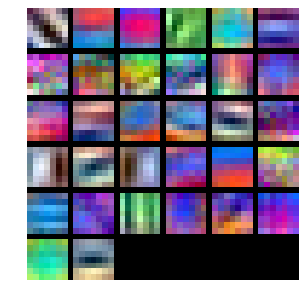

In [21]:
from annp.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Spatial Batch Normalization
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. As proposed in the original paper (link in `BatchNormalization.ipynb`), batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect every feature channel's statistics e.g. mean, variance to be relatively consistent both between different images, and different locations within the same image -- after all, every feature channel is produced by the same convolutional filter! Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over the minibatch dimension `N` as well the spatial dimensions `H` and `W`.


[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

## Spatial batch normalization: forward

In the file `annp/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [22]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [9.33463814 8.90909116 9.11056338]
  Stds:  [3.61447857 3.19347686 3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.18949336e-16  5.99520433e-16 -1.22124533e-16]
  Stds:  [0.99999962 0.99999951 0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [6. 7. 8.]
  Stds:  [2.99999885 3.99999804 4.99999798]


In [23]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [0.96718744 1.0299714  1.02887624 1.00585577]


## Spatial batch normalization: backward
In the file `annp/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [24]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

#You should expect errors of magnitudes between 1e-12~1e-06
_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.7866481929016103e-07
dgamma error:  7.0974817113608705e-12
dbeta error:  3.275608725278405e-12


## Train your best model

Try to get the best performance that you can on CIFAR-10 using a ConvNet. You can try some different parameters or add batch/layer normalization and dropout layer which are completed in annp/layers.py into your model for faster training.

### Things you can try:

1. Filter size: Different filters can extract different degree of image features
2. Number of filter: Do more or fewer better ?
3. Network architecture: The network above has two layers of trainable parameters. Can you do better with deeper network ? You can implement alternative architecture in the file annp/classifiers/cnn.py.

### Expectation

At last, you should be expected to train a ConvNet that gets at least 60% accuracy on the validation set.   
You should use the space below to experiment and train your network. The final cell should contain the training, validation and test set accuracies for your final trained network.   
You should write a report about what you did, any additional features that you implemented and any visualizations or graphs on evaluating your network.

### Attention

You should not be allowed to use any deep learning framework !!!

In [25]:
models=dict()
solvers=dict()

### test0：层的排列规律
INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC
其中*指的是重复次数，POOL?指的是一个可选的汇聚层。其中N >=0,通常N<=3,M>=0,K>=0,通常K<3。例如，下面是一些常见的网络结构规律。

In [43]:
def test0(index, conv_dims, affine_dims, data=data):
    global models, solvers
    np.random.seed(231)

    models[index] = AlternativeArchitecture(conv_dims=conv_dims, affine_dims=affine_dims, weight_scale=1e-2)

    solvers[index] = Solver(models[index], data,
                    num_epochs=15, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    verbose=True, print_every=980)
    solvers[index].train()

    # Print final training accuracy
    print(
        "Full data training accuracy:",
        solvers[index].check_accuracy(data['X_train'], data['y_train'])
    )

    # Print final validation accuracy
    print(
        "Full data validation accuracy:",
        solvers[index].check_accuracy(data['X_val'], data['y_val'])
    )

    plt.subplot(2, 1, 1)
    plt.plot(solvers[index].loss_history, 'o')
    plt.xlabel('iteration')
    plt.ylabel('loss')

    plt.subplot(2, 1, 2)
    plt.plot(solvers[index].train_acc_history, '-o')
    plt.plot(solvers[index].val_acc_history, '-o')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

def visualize_first_layer_filters(index):
    global models
    grid = visualize_grid(models[index].params['conv_W0'].transpose(0, 2, 3, 1))
    plt.imshow(grid.astype('uint8'))
    plt.axis('off')
    plt.gcf().set_size_inches(5, 5)
    plt.show()

#### INPUT -> FC
实现一个线性分类器，此处N = M = K = 0。效果不佳。

(Iteration 1 / 14700) loss: 52.434561
(Epoch 0 / 15) train acc: 0.179000; val_acc: 0.180000
(Epoch 1 / 15) train acc: 0.283000; val_acc: 0.290000
(Iteration 981 / 14700) loss: 33.470381
(Epoch 2 / 15) train acc: 0.306000; val_acc: 0.281000
(Iteration 1961 / 14700) loss: 40.427456
(Epoch 3 / 15) train acc: 0.301000; val_acc: 0.311000
(Iteration 2941 / 14700) loss: 48.908560
(Epoch 4 / 15) train acc: 0.299000; val_acc: 0.275000
(Iteration 3921 / 14700) loss: 35.221550
(Epoch 5 / 15) train acc: 0.276000; val_acc: 0.257000
(Iteration 4901 / 14700) loss: 37.834075
(Epoch 6 / 15) train acc: 0.327000; val_acc: 0.326000
(Iteration 5881 / 14700) loss: 38.786841
(Epoch 7 / 15) train acc: 0.314000; val_acc: 0.283000
(Iteration 6861 / 14700) loss: 44.434053
(Epoch 8 / 15) train acc: 0.337000; val_acc: 0.299000
(Iteration 7841 / 14700) loss: 28.490706
(Epoch 9 / 15) train acc: 0.294000; val_acc: 0.290000
(Iteration 8821 / 14700) loss: 25.555542
(Epoch 10 / 15) train acc: 0.352000; val_acc: 0.305000

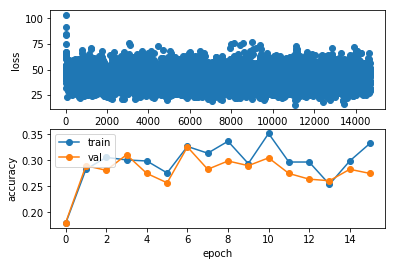

Wall time: 33.2 s


In [32]:
%%time
test0(0, tuple(), tuple())

#### INPUT -> CONV -> RELU -> FC
已经达到60%的要求。

(Iteration 1 / 14700) loss: 2.297199
(Epoch 0 / 15) train acc: 0.197000; val_acc: 0.190000
(Epoch 1 / 15) train acc: 0.648000; val_acc: 0.584000
(Iteration 981 / 14700) loss: 1.239579
(Epoch 2 / 15) train acc: 0.701000; val_acc: 0.591000
(Iteration 1961 / 14700) loss: 0.679621
(Epoch 3 / 15) train acc: 0.760000; val_acc: 0.612000
(Iteration 2941 / 14700) loss: 0.770461
(Epoch 4 / 15) train acc: 0.804000; val_acc: 0.633000
(Iteration 3921 / 14700) loss: 0.482815
(Epoch 5 / 15) train acc: 0.861000; val_acc: 0.633000
(Iteration 4901 / 14700) loss: 0.533430
(Epoch 6 / 15) train acc: 0.896000; val_acc: 0.643000
(Iteration 5881 / 14700) loss: 0.398794
(Epoch 7 / 15) train acc: 0.924000; val_acc: 0.668000
(Iteration 6861 / 14700) loss: 0.235213
(Epoch 8 / 15) train acc: 0.932000; val_acc: 0.658000
(Iteration 7841 / 14700) loss: 0.272801
(Epoch 9 / 15) train acc: 0.943000; val_acc: 0.650000
(Iteration 8821 / 14700) loss: 0.189178
(Epoch 10 / 15) train acc: 0.968000; val_acc: 0.623000
(Iteratio

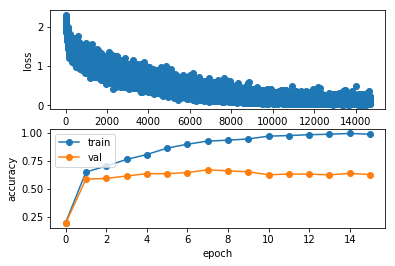

Wall time: 1h 7min 49s


In [34]:
%%time
test0(1, ((32, 3, 3, {"stride": 1, "pad": (3 - 1) // 2}, None, {'eps': 1e-5}),),
      ((100, {'eps': 1e-5}),))

#### INPUT -> [CONV -> RELU -> POOL]*2 -> FC -> RELU -> FC
此处在每个汇聚层之间有一个卷积层。较前一个准确率提高5%，训练时间接近上一个模型的两倍。

(Iteration 1 / 14700) loss: 2.297591
(Epoch 0 / 15) train acc: 0.156000; val_acc: 0.150000
(Epoch 1 / 15) train acc: 0.661000; val_acc: 0.641000
(Iteration 981 / 14700) loss: 0.645524
(Epoch 2 / 15) train acc: 0.765000; val_acc: 0.701000
(Iteration 1961 / 14700) loss: 0.648614
(Epoch 3 / 15) train acc: 0.791000; val_acc: 0.710000
(Iteration 2941 / 14700) loss: 0.661866
(Epoch 4 / 15) train acc: 0.803000; val_acc: 0.716000
(Iteration 3921 / 14700) loss: 0.666137
(Epoch 5 / 15) train acc: 0.838000; val_acc: 0.715000
(Iteration 4901 / 14700) loss: 0.529627
(Epoch 6 / 15) train acc: 0.879000; val_acc: 0.720000
(Iteration 5881 / 14700) loss: 0.469007
(Epoch 7 / 15) train acc: 0.877000; val_acc: 0.723000
(Iteration 6861 / 14700) loss: 0.370120
(Epoch 8 / 15) train acc: 0.895000; val_acc: 0.710000
(Iteration 7841 / 14700) loss: 0.220058
(Epoch 9 / 15) train acc: 0.928000; val_acc: 0.718000
(Iteration 8821 / 14700) loss: 0.198525
(Epoch 10 / 15) train acc: 0.925000; val_acc: 0.722000
(Iteratio

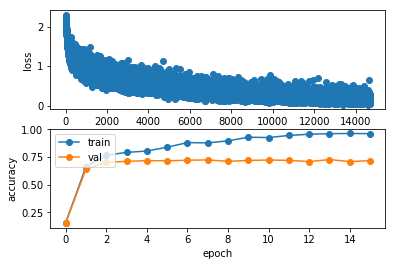

Wall time: 45min 42s


In [35]:
%%time
test0(2, ((32, 3, 3, {"stride": 1, "pad": (3 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None),
           (32, 3, 3, {"stride": 1, "pad": (3 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None)),
      ((100, {'eps': 1e-5}),))

#### INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC
此处每个汇聚层前有两个卷积层，这个思路适用于更大更深的网络，因为在执行具有破坏性的汇聚操作前，多重的卷积层可以从输入数据中学习到更多的复杂特征。准确率较前一个模型有%2的提升，训练时间接近前一个模型的两倍。由于增加深度提升不高，运算时间长，而且这个模型似乎还没饱和，后面将使用此模型继续调参。

(Iteration 1 / 14700) loss: 2.321704
(Epoch 0 / 15) train acc: 0.113000; val_acc: 0.082000
(Epoch 1 / 15) train acc: 0.599000; val_acc: 0.620000
(Iteration 981 / 14700) loss: 0.974621
(Epoch 2 / 15) train acc: 0.728000; val_acc: 0.676000
(Iteration 1961 / 14700) loss: 0.871618
(Epoch 3 / 15) train acc: 0.786000; val_acc: 0.745000
(Iteration 2941 / 14700) loss: 0.649741
(Epoch 4 / 15) train acc: 0.819000; val_acc: 0.770000
(Iteration 3921 / 14700) loss: 0.607388
(Epoch 5 / 15) train acc: 0.807000; val_acc: 0.763000
(Iteration 4901 / 14700) loss: 0.775258
(Epoch 6 / 15) train acc: 0.804000; val_acc: 0.757000
(Iteration 5881 / 14700) loss: 0.391978
(Epoch 7 / 15) train acc: 0.844000; val_acc: 0.789000
(Iteration 6861 / 14700) loss: 0.501225
(Epoch 8 / 15) train acc: 0.870000; val_acc: 0.777000
(Iteration 7841 / 14700) loss: 0.410105
(Epoch 9 / 15) train acc: 0.885000; val_acc: 0.796000
(Iteration 8821 / 14700) loss: 0.361969
(Epoch 10 / 15) train acc: 0.883000; val_acc: 0.791000
(Iteratio

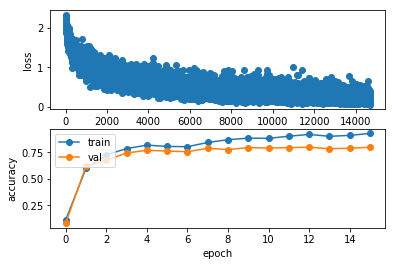

Wall time: 1h 56min 41s


In [36]:
%%time
test0(3, ((32, 3, 3, {"stride": 1, "pad": (3 - 1) // 2}, None, {'eps': 1e-5}),
           (32, 3, 3, {"stride": 1, "pad": (3 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None),
           (32, 3, 3, {"stride": 1, "pad": (3 - 1) // 2}, None, {'eps': 1e-5}),
           (32, 3, 3, {"stride": 1, "pad": (3 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None),
           (32, 3, 3, {"stride": 1, "pad": (3 - 1) // 2}, None, {'eps': 1e-5}),
          (32, 3, 3, {"stride": 1, "pad": (3 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None)),
      ((100, {'eps': 1e-5}),
       (100, {'eps': 1e-5})))

#### 观察卷积核
由于是$3\times3$卷积核，提取的特征非常抽象，但也有点模糊。

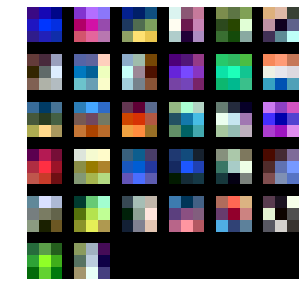

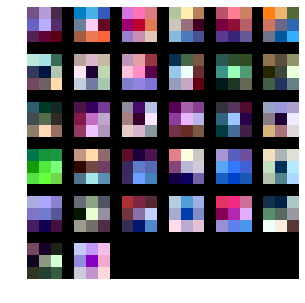

In [50]:
visualize_first_layer_filters(1)
visualize_first_layer_filters(3)

### 层的尺寸设置规律

#### 输入层
（包含图像的）应该能被2整除很多次。常用数字包括32（比如CIFAR-10），64，96（比如STL-10）或224（比如ImageNet卷积神经网络），384和512。由于数据输入大小已经确定，在此不做更多调整。

#### 卷积层
应该使用小尺寸滤波器（比如3x3或最多5x5），使用步长$S=1$。还有一点非常重要，就是对输入数据进行零填充，这样卷积层就不会改变输入数据在空间维度上的尺寸。一般对于任意$F$，当$P=\frac{F-1}2$的时候能保持输入尺寸。如果必须使用更大的滤波器尺寸（比如7x7之类），通常只用在第一个面对原始图像的卷积层上。

##### test1：滤波器尺寸

In [67]:
def test1(index, dim, data=data):
    global models, solvers
    np.random.seed(231)

    models[index] = AlternativeArchitecture(
        conv_dims=((32, dim, dim, {"stride": 1, "pad": (dim - 1) // 2}, None, {'eps': 1e-5}),
                   (32, dim, dim, {"stride": 1, "pad": (dim - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None),
                   (32, dim, dim, {"stride": 1, "pad": (dim - 1) // 2}, None, {'eps': 1e-5}),
                   (32, dim, dim, {"stride": 1, "pad": (dim - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None),
                   (32, dim, dim, {"stride": 1, "pad": (dim - 1) // 2}, None, {'eps': 1e-5}),
                   (32, dim, dim, {"stride": 1, "pad": (dim - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None)),
        affine_dims=((100, {'eps': 1e-5}),(100, {'eps': 1e-5})), weight_scale=1e-2)

    solvers[index] = Solver(models[index], data,
                    num_epochs=15, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    verbose=True, print_every=980)
    solvers[index].train()

    # Print final training accuracy
    print(
        "Full data training accuracy:",
        solvers[index].check_accuracy(data['X_train'], data['y_train'])
    )

    # Print final validation accuracy
    print(
        "Full data validation accuracy:",
        solvers[index].check_accuracy(data['X_val'], data['y_val'])
    )

    plt.subplot(2, 1, 1)
    plt.plot(solvers[index].loss_history, 'o')
    plt.xlabel('iteration')
    plt.ylabel('loss')

    plt.subplot(2, 1, 2)
    plt.plot(solvers[index].train_acc_history, '-o')
    plt.plot(solvers[index].val_acc_history, '-o')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

##### 5x5
效果最好，因为卷积核大，感受野大，收到的图片信息更多，但是计算缓慢。后面选用此卷积核大小继续实验。

(Iteration 1 / 14700) loss: 2.305221
(Epoch 0 / 15) train acc: 0.103000; val_acc: 0.087000
(Epoch 1 / 15) train acc: 0.582000; val_acc: 0.577000
(Iteration 981 / 14700) loss: 1.244489
(Epoch 2 / 15) train acc: 0.723000; val_acc: 0.712000
(Iteration 1961 / 14700) loss: 0.751768
(Epoch 3 / 15) train acc: 0.760000; val_acc: 0.739000
(Iteration 2941 / 14700) loss: 0.636542
(Epoch 4 / 15) train acc: 0.786000; val_acc: 0.751000
(Iteration 3921 / 14700) loss: 0.412511
(Epoch 5 / 15) train acc: 0.821000; val_acc: 0.774000
(Iteration 4901 / 14700) loss: 0.663249
(Epoch 6 / 15) train acc: 0.841000; val_acc: 0.776000
(Iteration 5881 / 14700) loss: 0.346056
(Epoch 7 / 15) train acc: 0.844000; val_acc: 0.778000
(Iteration 6861 / 14700) loss: 0.345217
(Epoch 8 / 15) train acc: 0.843000; val_acc: 0.775000
(Iteration 7841 / 14700) loss: 0.473615
(Epoch 9 / 15) train acc: 0.882000; val_acc: 0.795000
(Iteration 8821 / 14700) loss: 0.340153
(Epoch 10 / 15) train acc: 0.878000; val_acc: 0.813000
(Iteratio

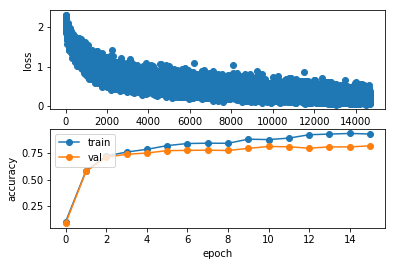

Wall time: 3h 10min 52s


In [78]:
%%time
test1(4, 5)

##### 7x7
效果弱于3x3，可能原因是大的卷积核泛化能力差（考虑非常大的卷积核，输入就是训练数据的整张图片，难以提取抽象的特征，如边的特征）。另外训练非常缓慢。

(Iteration 1 / 14700) loss: 2.303385
(Epoch 0 / 15) train acc: 0.094000; val_acc: 0.107000
(Epoch 1 / 15) train acc: 0.539000; val_acc: 0.559000
(Iteration 981 / 14700) loss: 1.044496
(Epoch 2 / 15) train acc: 0.664000; val_acc: 0.668000
(Iteration 1961 / 14700) loss: 0.868659
(Epoch 3 / 15) train acc: 0.705000; val_acc: 0.711000
(Iteration 2941 / 14700) loss: 0.793630
(Epoch 4 / 15) train acc: 0.756000; val_acc: 0.735000
(Iteration 3921 / 14700) loss: 0.872667
(Epoch 5 / 15) train acc: 0.776000; val_acc: 0.735000
(Iteration 4901 / 14700) loss: 0.553044
(Epoch 6 / 15) train acc: 0.766000; val_acc: 0.742000
(Iteration 5881 / 14700) loss: 0.448361
(Epoch 7 / 15) train acc: 0.829000; val_acc: 0.760000
(Iteration 6861 / 14700) loss: 0.376799
(Epoch 8 / 15) train acc: 0.818000; val_acc: 0.778000
(Iteration 7841 / 14700) loss: 0.444658
(Epoch 9 / 15) train acc: 0.843000; val_acc: 0.794000
(Iteration 8821 / 14700) loss: 0.442537
(Epoch 10 / 15) train acc: 0.853000; val_acc: 0.782000
(Iteratio

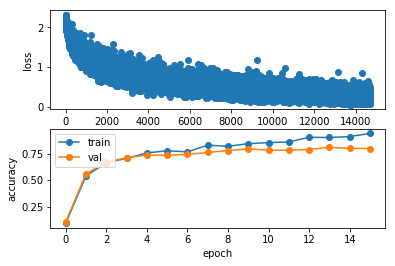

Wall time: 5h 31min 16s


In [79]:
%%time
test1(5, 7)

##### 观察卷积核
3x3的卷积核过于模糊，5x5的卷积核适中，7x7的卷积核不够抽象。

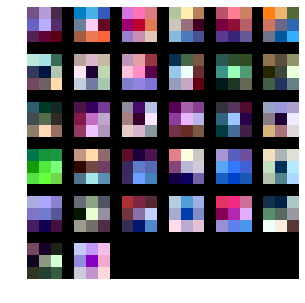

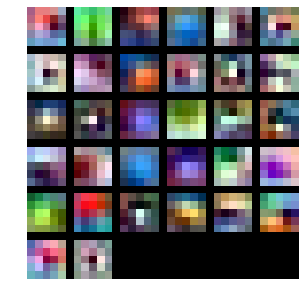

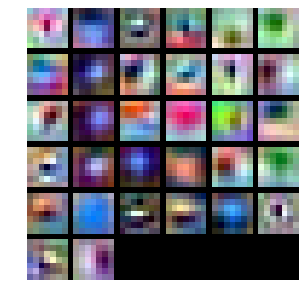

In [81]:
visualize_first_layer_filters(3)
visualize_first_layer_filters(4)
visualize_first_layer_filters(5)

#### test2：滤波器数量

In [82]:
def test2(index, F, data=data):
    global models, solvers
    np.random.seed(231)

    models[index] = AlternativeArchitecture(
        conv_dims=((F, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, None, {'eps': 1e-5}),
                   (F, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None),
                   (F, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, None, {'eps': 1e-5}),
                   (F, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None),
                   (F, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, None, {'eps': 1e-5}),
                   (F, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None)),
        affine_dims=((100, {'eps': 1e-5}),(100, {'eps': 1e-5})), weight_scale=1e-2)

    solvers[index] = Solver(models[index], data,
                    num_epochs=15, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    verbose=True, print_every=980)
    solvers[index].train()

    # Print final training accuracy
    print(
        "Full data training accuracy:",
        solvers[index].check_accuracy(data['X_train'], data['y_train'])
    )

    # Print final validation accuracy
    print(
        "Full data validation accuracy:",
        solvers[index].check_accuracy(data['X_val'], data['y_val'])
    )

    plt.subplot(2, 1, 1)
    plt.plot(solvers[index].loss_history, 'o')
    plt.xlabel('iteration')
    plt.ylabel('loss')

    plt.subplot(2, 1, 2)
    plt.plot(solvers[index].train_acc_history, '-o')
    plt.plot(solvers[index].val_acc_history, '-o')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

##### 16
滤波器数量少，容易丢失特征，导致欠拟合。

(Iteration 1 / 14700) loss: 2.299368
(Epoch 0 / 15) train acc: 0.094000; val_acc: 0.088000
(Epoch 1 / 15) train acc: 0.591000; val_acc: 0.575000
(Iteration 981 / 14700) loss: 1.196574
(Epoch 2 / 15) train acc: 0.652000; val_acc: 0.637000
(Iteration 1961 / 14700) loss: 1.142005
(Epoch 3 / 15) train acc: 0.755000; val_acc: 0.706000
(Iteration 2941 / 14700) loss: 0.890662
(Epoch 4 / 15) train acc: 0.745000; val_acc: 0.729000
(Iteration 3921 / 14700) loss: 0.424433
(Epoch 5 / 15) train acc: 0.776000; val_acc: 0.750000
(Iteration 4901 / 14700) loss: 0.660225
(Epoch 6 / 15) train acc: 0.753000; val_acc: 0.726000
(Iteration 5881 / 14700) loss: 0.558097
(Epoch 7 / 15) train acc: 0.773000; val_acc: 0.705000
(Iteration 6861 / 14700) loss: 0.636164
(Epoch 8 / 15) train acc: 0.788000; val_acc: 0.747000
(Iteration 7841 / 14700) loss: 0.598561
(Epoch 9 / 15) train acc: 0.786000; val_acc: 0.715000
(Iteration 8821 / 14700) loss: 0.561053
(Epoch 10 / 15) train acc: 0.837000; val_acc: 0.761000
(Iteratio

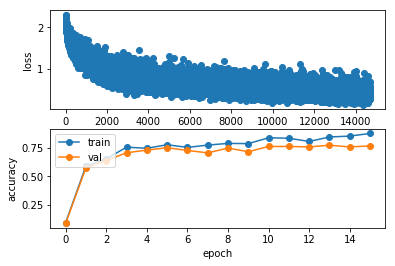

Wall time: 1h 35min 13s


In [88]:
%%time
test2(6, 16)

##### 64
滤波器数量过多，训练时间长且容易过拟合。

(Iteration 1 / 14700) loss: 2.301801
(Epoch 0 / 15) train acc: 0.112000; val_acc: 0.113000
(Epoch 1 / 15) train acc: 0.530000; val_acc: 0.568000
(Iteration 981 / 14700) loss: 1.425419
(Epoch 2 / 15) train acc: 0.677000; val_acc: 0.685000
(Iteration 1961 / 14700) loss: 0.770257
(Epoch 3 / 15) train acc: 0.751000; val_acc: 0.743000
(Iteration 2941 / 14700) loss: 0.538720
(Epoch 4 / 15) train acc: 0.813000; val_acc: 0.768000
(Iteration 3921 / 14700) loss: 0.654712
(Epoch 5 / 15) train acc: 0.836000; val_acc: 0.801000
(Iteration 4901 / 14700) loss: 0.470146
(Epoch 6 / 15) train acc: 0.864000; val_acc: 0.810000
(Iteration 5881 / 14700) loss: 0.570166
(Epoch 7 / 15) train acc: 0.891000; val_acc: 0.819000
(Iteration 6861 / 14700) loss: 0.244067
(Epoch 8 / 15) train acc: 0.888000; val_acc: 0.806000
(Iteration 7841 / 14700) loss: 0.096247
(Epoch 9 / 15) train acc: 0.908000; val_acc: 0.797000
(Iteration 8821 / 14700) loss: 0.290975
(Epoch 10 / 15) train acc: 0.925000; val_acc: 0.828000
(Iteratio

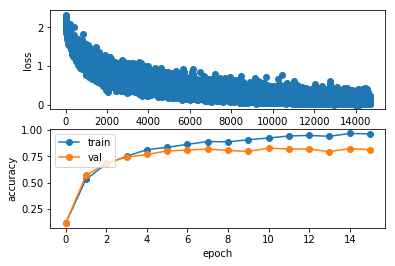

Wall time: 6h 36min 30s


In [89]:
%%time
test2(7, 64)

#### 汇聚层
负责对输入数据的空间维度进行降采样。最常用的设置是用用2x2感受野的最大值汇聚，步长为2。注意这一操作将会把输入数据中75%的激活数据丢弃（因为对宽度和高度都进行了2的降采样）。另一个不那么常用的设置是使用3x3的感受野，步长为2。最大值汇聚的感受野尺寸很少有超过3的，因为汇聚操作过于激烈，易造成数据信息丢失，这通常会导致算法性能变差。

##### 重叠汇聚
需要输入大小是奇数，而且更大感受野往往对网络有破坏性。

#### 归一化层
以上已经使用了bn归一化层。

#### test3：全连接层

In [112]:
def test3(index, dim, data=data):
    global models, solvers
    np.random.seed(231)

    models[index] = AlternativeArchitecture(
        conv_dims=((32, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, None, {'eps': 1e-5}),
                   (32, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None),
                   (32, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, None, {'eps': 1e-5}),
                   (32, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None),
                   (32, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, None, {'eps': 1e-5}),
                   (32, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None)),
        affine_dims=((dim, {'eps': 1e-5}),
                     (dim, {'eps': 1e-5})), weight_scale=1e-2)

    solvers[index] = Solver(models[index], data,
                    num_epochs=15, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    verbose=True, print_every=980)
    solvers[index].train()

    # Print final training accuracy
    print(
        "Full data training accuracy:",
        solvers[index].check_accuracy(data['X_train'], data['y_train'])
    )

    # Print final validation accuracy
    print(
        "Full data validation accuracy:",
        solvers[index].check_accuracy(data['X_val'], data['y_val'])
    )

    plt.subplot(2, 1, 1)
    plt.plot(solvers[index].loss_history, 'o')
    plt.xlabel('iteration')
    plt.ylabel('loss')

    plt.subplot(2, 1, 2)
    plt.plot(solvers[index].train_acc_history, '-o')
    plt.plot(solvers[index].val_acc_history, '-o')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

##### 50
效果不好

Wall time: 0 ns
(Iteration 1 / 14700) loss: 2.318802
(Epoch 0 / 15) train acc: 0.100000; val_acc: 0.102000
(Epoch 1 / 15) train acc: 0.601000; val_acc: 0.570000
(Iteration 981 / 14700) loss: 1.110101
(Epoch 2 / 15) train acc: 0.664000; val_acc: 0.658000
(Iteration 1961 / 14700) loss: 0.806169
(Epoch 3 / 15) train acc: 0.761000; val_acc: 0.728000
(Iteration 2941 / 14700) loss: 0.675194
(Epoch 4 / 15) train acc: 0.782000; val_acc: 0.758000
(Iteration 3921 / 14700) loss: 0.776830
(Epoch 5 / 15) train acc: 0.797000; val_acc: 0.778000
(Iteration 4901 / 14700) loss: 0.527192
(Epoch 6 / 15) train acc: 0.845000; val_acc: 0.772000
(Iteration 5881 / 14700) loss: 0.497206
(Epoch 7 / 15) train acc: 0.853000; val_acc: 0.789000
(Iteration 6861 / 14700) loss: 0.366833
(Epoch 8 / 15) train acc: 0.856000; val_acc: 0.799000
(Iteration 7841 / 14700) loss: 0.399549
(Epoch 9 / 15) train acc: 0.865000; val_acc: 0.801000
(Iteration 8821 / 14700) loss: 0.282819
(Epoch 10 / 15) train acc: 0.867000; val_acc: 0.

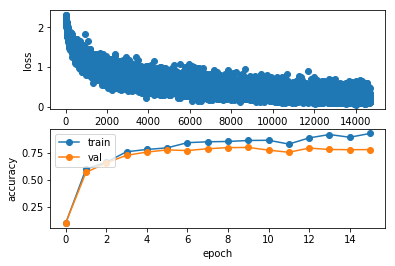

In [116]:
%time
test3(8, 50)

##### 200
效果不好

Wall time: 0 ns
(Iteration 1 / 14700) loss: 2.293937
(Epoch 0 / 15) train acc: 0.106000; val_acc: 0.105000
(Epoch 1 / 15) train acc: 0.563000; val_acc: 0.594000
(Iteration 981 / 14700) loss: 1.423291
(Epoch 2 / 15) train acc: 0.710000; val_acc: 0.692000
(Iteration 1961 / 14700) loss: 0.908434
(Epoch 3 / 15) train acc: 0.747000; val_acc: 0.739000
(Iteration 2941 / 14700) loss: 0.375763
(Epoch 4 / 15) train acc: 0.791000; val_acc: 0.744000
(Iteration 3921 / 14700) loss: 0.584675
(Epoch 5 / 15) train acc: 0.835000; val_acc: 0.765000
(Iteration 4901 / 14700) loss: 0.667376
(Epoch 6 / 15) train acc: 0.835000; val_acc: 0.765000
(Iteration 5881 / 14700) loss: 0.362273
(Epoch 7 / 15) train acc: 0.859000; val_acc: 0.780000
(Iteration 6861 / 14700) loss: 0.506374
(Epoch 8 / 15) train acc: 0.844000; val_acc: 0.743000
(Iteration 7841 / 14700) loss: 0.342284
(Epoch 9 / 15) train acc: 0.877000; val_acc: 0.792000
(Iteration 8821 / 14700) loss: 0.391893
(Epoch 10 / 15) train acc: 0.903000; val_acc: 0.

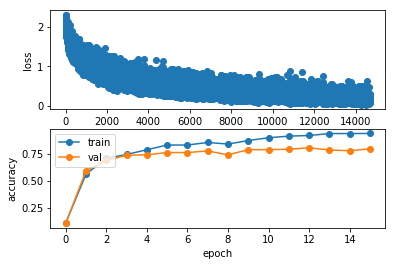

In [117]:
%time
test3(9, 200)

### 最终的训练
设置num_epochs=100，预计30小时结束。

In [126]:
%time
index=10
np.random.seed(231)

models[index] = AlternativeArchitecture(
    conv_dims=((32, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, None, {'eps': 1e-5}),
               (32, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None),
               (32, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, None, {'eps': 1e-5}),
               (32, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None),
               (32, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, None, {'eps': 1e-5}),
               (32, 5, 5, {"stride": 1, "pad": (5 - 1) // 2}, {"pool_height": 2, "pool_width": 2, "stride": 2}, None)),
    affine_dims=((100, {'eps': 1e-5}),(100, {'eps': 1e-5})), weight_scale=1e-2)

solvers[index] = Solver(models[index], data,
                num_epochs=200, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=980)
solvers[index].train()

# Print final training accuracy
print(
    "Full data training accuracy:",
    solvers[index].check_accuracy(data['X_train'], data['y_train'])
)

# Print final validation accuracy
print(
    "Full data validation accuracy:",
    solvers[index].check_accuracy(data['X_val'], data['y_val'])
)

plt.subplot(2, 1, 1)
plt.plot(solvers[index].loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solvers[index].train_acc_history, '-o')
plt.plot(solvers[index].val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Wall time: 0 ns
(Iteration 1 / 196000) loss: 2.305221
(Epoch 0 / 200) train acc: 0.103000; val_acc: 0.087000
(Epoch 1 / 200) train acc: 0.582000; val_acc: 0.577000
(Iteration 981 / 196000) loss: 1.244489
(Epoch 2 / 200) train acc: 0.723000; val_acc: 0.712000
(Iteration 1961 / 196000) loss: 0.751768
(Epoch 3 / 200) train acc: 0.760000; val_acc: 0.739000
(Iteration 2941 / 196000) loss: 0.636542
(Epoch 4 / 200) train acc: 0.786000; val_acc: 0.751000
(Iteration 3921 / 196000) loss: 0.412511
(Epoch 5 / 200) train acc: 0.821000; val_acc: 0.774000
(Iteration 4901 / 196000) loss: 0.663249
(Epoch 6 / 200) train acc: 0.841000; val_acc: 0.776000
(Iteration 5881 / 196000) loss: 0.346056
(Epoch 7 / 200) train acc: 0.844000; val_acc: 0.778000
(Iteration 6861 / 196000) loss: 0.345217
(Epoch 8 / 200) train acc: 0.843000; val_acc: 0.775000
(Iteration 7841 / 196000) loss: 0.473615
(Epoch 9 / 200) train acc: 0.882000; val_acc: 0.795000
(Iteration 8821 / 196000) loss: 0.340153
(Epoch 10 / 200) train acc: 

KeyboardInterrupt: 

In [127]:
# Print final training accuracy
print(
    "Full data training accuracy:",
    solvers[index].check_accuracy(data['X_train'], data['y_train'])
)

# Print final validation accuracy
print(
    "Full data validation accuracy:",
    solvers[index].check_accuracy(data['X_val'], data['y_val'])
)

Full data training accuracy: 0.9978163265306123
Full data validation accuracy: 0.815


此时训练集已经基本收敛，验证集并无太大提升。可能原因是前面在epoch=15的基础上调参，已经调到接近局部最优解。

### 总结
1. 层数越多，训练效果越好，但训练时间越长。
2. 滤波器尺寸过小，感受野小，收集到的图片信息少；滤波器尺寸过大，感受野大，提取出的特征不够抽象。
3. 滤波器数量过多拖慢训练，容易过拟合；滤波器数量过少容易丢失特征。
4. 全连接层维度的影响类似滤波器数量的影响。